 # dataset of unknown size, unknown outliers 

 The challenge is to detect outliers without prior knowledge of the contamination rate.
 Steps:
 1. We can still use Isolation Forest because it is efficient and works well without labels.
 2. However, we don't set `contamination` to a fixed value. Instead, we can:
    a. Use the default 'auto' (which is 0.1) and then adjust based on the problem.
    b. Analyze the anomaly scores to set a threshold (e.g., by percentiles or by inspecting the distribution of scores).
 Approach:
 - Fit the Isolation Forest without specifying `contamination` (so it uses 'auto' by default) and obtain the anomaly scores.
 - The anomaly scores are in the range [-1, 1], where:
      - Scores close to -1 indicate outliers.
      - Scores close to 1 indicate inliers.
We can then decide on a threshold. One common way is to set the threshold such that a certain percentage (e.g., 2%, 5%) of the data is considered as outliers.
   
But without prior knowledge, we can look at the distribution of scores and look for a natural break (e.g., using a histogram or the interquartile range).
   
Alternatively, we can use the `contamination='auto'` and then validate the outliers if we have domain knowledge or by using other methods.
 However, note that the `contamination` parameter in Isolation Forest is used to set the threshold on the scores. Specifically, the threshold is set so that the proportion of outliers is equal to `contamination`.

<h3 style='color:black;'>How to determine the contamination rate when unknown?</h3>

- One approach is to use the "elbow method" on the sorted anomaly scores. We can look for a point where the scores drop significantly (like in the scree plot of PCA).
  
- Another approach is to use the mean anomaly score plus 2 or 3 standard deviations as the threshold (if we assume the scores are normally distributed, which they might not be).

- But a more robust method is to use the percentile of the scores. For example, we might flag the 5% of points with the lowest scores (most negative) as outliers.
 However, without any prior, we might start by setting the threshold at the 5th percentile (or 95th percentile if we consider the absolute value) and then adjust.

<h3 style='color:black;'>Key Strategy: Leverage Anomaly Scores</h3>

Instead of relying on a fixed contamination parameter, we use the raw anomaly scores to identify outliers. Isolation Forest outputs scores where:

- Lower scores → More likely outliers (negative values)

- Higher scores → Inliers (positive values)

We'll determine the threshold dynamically using statistical methods.

<h3 style='color:black;'>Step-by-Step Approach</h3>

<h3 style='color:black;'>1. Train Isolation Forest with Default Settings</h3>

In [ ]:
model = IsolationForest(random_state=42)
model.fit(X)  # No contamination parameter
scores = model.decision_function(X)  # Get raw anomaly scores

<h3 style='color:black;'>2. Determine Threshold Dynamically</h3>

Use one of these methods:

- Percentile-Based: Flag lowest 1-5% as outliers

In [ ]:
threshold = np.percentile(scores, 2)  # Flag bottom 2%

- IQR Rule: Robust for skewed distributions

In [ ]:
Q1 = np.percentile(scores, 25)
Q3 = np.percentile(scores, 75)
IQR = Q3 - Q1
threshold = Q1 - 1.5 * IQR  # Classic outlier cutoff

- Visual Inspection: Plot score distribution

<h3 style='color:black;'>3. Validate with Clustering (Optional)</h3>

In [ ]:
from sklearn.cluster import DBSCAN
outliers_if = scores < threshold
db = DBSCAN(eps=0.5).fit(X)
outliers_db = db.labels_ == -1
consensus = outliers_if & outliers_db  # Intersection

<h3 style='color:black;'>Full Implementation Example</h3>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [2]:
# Generate dataset with unknown outlier ratio (5% outliers)
np.random.seed(42)
inliers = np.random.randn(950, 2)  # 95% inliers
outliers = np.random.uniform(-10, 10, (50, 2))  # 5% outliers
X = np.vstack([inliers, outliers])

In [3]:
# 1. Train Isolation Forest
model = IsolationForest(random_state=42)
model.fit(X)
scores = model.decision_function(X)

In [4]:
# 2. Determine threshold using IQR rule
Q1 = np.percentile(scores, 25)
Q3 = np.percentile(scores, 75)
IQR = Q3 - Q1
threshold = Q1 - 1.5 * IQR

In [5]:
# Identify outliers
outlier_mask = scores < threshold
inlier_mask = ~outlier_mask

In [6]:
# 3. Plot results
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

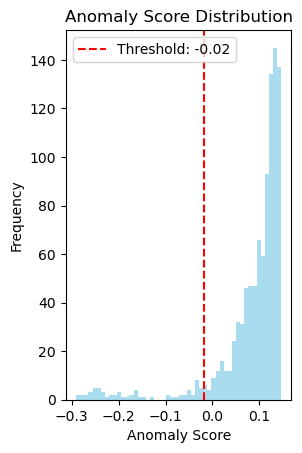

In [7]:
# Score distribution
plt.subplot(121)
plt.hist(scores, bins=50, alpha=0.7, color="skyblue")
plt.axvline(threshold, color="red", linestyle="--", 
            label=f'Threshold: {threshold:.2f}')
plt.title("Anomaly Score Distribution")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.legend()

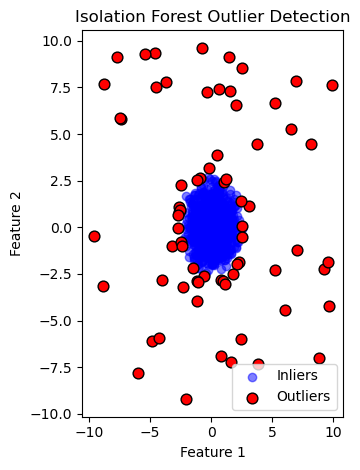

Detected outliers: 70 (7.0%)


In [10]:
# Data space
plt.subplot(122)
plt.scatter(X[inlier_mask, 0], X[inlier_mask, 1], 
            color="blue", alpha=0.5, label="Inliers")
plt.scatter(X[outlier_mask, 0], X[outlier_mask, 1], 
            color="red", s=60, edgecolor='k', label="Outliers")
plt.title("Isolation Forest Outlier Detection")
plt.xlabel("Feature 1")

plt.ylabel("Feature 2")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Detected outliers: {outlier_mask.sum()} ({outlier_mask.sum()/len(X):.1%})")

<h3 style='color:black;'>Interpretation Guide</h3>

<h3 style='color:black;'>1. Score Distribution Plot (Left):</h3>

Look for left-skewed distribution

The red dashed line shows the automatic threshold

Points left of threshold are flagged as outliers

<h3 style='color:black;'>2. Scatter Plot (Right):</h3>

Red points: Detected outliers

Blue points: Inliers

<h3 style='color:black;'>Validation:</h3>

Compare outlier count with domain knowledge

Adjust percentile/IQR multiplier if needed

Use clustering for consensus (shown in optional step)

<h3 style='color:black;'>Key Advantages</h3>

- No prior knowledge needed about dataset size or outlier proportion

- Adaptive thresholding handles skewed distributions

- Visual diagnostics provide intuitive validation

- Combined techniques (IQR + clustering) increase robustness

This approach works effectively for real-world datasets where outlier characteristics are unknown. For critical applications, iterate between automatic detection and domain expert validation.